In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# Data Ingestion
## Voxelizzazioni
Definisco la cartella contenente i PDB

In [3]:
data_folder = '..\\pocketAnalysis\\refined\\'

Definisco la funzione di estrazione voxelizzazioni

representation...


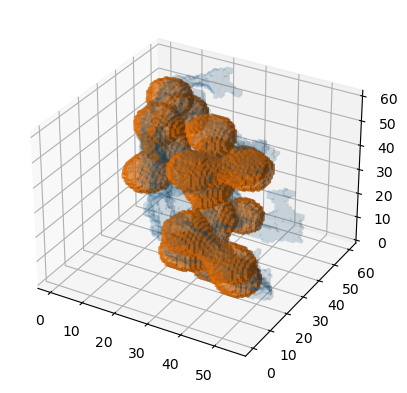

In [4]:
def extract_voxelization_and_anchor_points_voxelization(filename):
    X = list()                            # coordinate atomiche
    A = list()                            # anchor points
    
    file1 = open(filename, 'r')           # leggo il file
    Lines = file1.readlines()             # estraggo le linee
    
    sparse = list()
    
    x_min,y_min,z_min,x_max,y_max,z_max = 0,0,0,0,0,0
    
    for line in Lines:
        if line.startswith("ANCHOR"):
            A.append(np.array(line.split()[1:]).astype(float))
        if line.startswith("GRIDG"):
            data = np.array(line.split()[2:]).astype(float)
            x_min,y_min,z_min,x_max,y_max,z_max = data[0],data[1],data[2],data[3],data[4],data[5]
        if line.startswith("GRIDVX"):
            coords = np.array(line.split()[1:4]).astype(int)
            if line.split()[-2] == 'P':
                sparse.append(coords)
    
    sparse = np.array(sparse).astype(int)
    grid = np.zeros( (
        np.max(sparse[:,0])+1,
        np.max(sparse[:,1])+1,
        np.max(sparse[:,2])+1
        )
    )
    
    anchor_grid = grid.copy()

    X   = jnp.linspace(x_min,x_max, grid.shape[0])
    Y   = jnp.linspace(y_min,y_max, grid.shape[1])
    Z   = jnp.linspace(z_min,z_max, grid.shape[2])
    
    XYZ = jnp.meshgrid(X,Y,Z, indexing = 'ij')
    
    for s in sparse:
        grid[s[0],s[1],s[2]] = 1.
    
    for a in A:
        a = jnp.array(np.array(a))
        sigma = 15.
        anchor_grid =  (
                                anchor_grid +
                                jax.vmap(
                                lambda x,y,z: jnp.exp( - ((x - a[0])**2 + (y - a[1])**2 + (z - a[2])**2)/sigma )
                                )(
                                    XYZ[0],XYZ[1],XYZ[2]
                                )
                        )

    anchor_grid = np.array(anchor_grid)
    anchor_grid = (anchor_grid - anchor_grid.min()) / (anchor_grid.max() - anchor_grid.min())
    return grid,anchor_grid
vox,anchorvox = extract_voxelization_and_anchor_points_voxelization(data_folder + r"1ezq\1ezq_pocket.ligen.pdb")
print("representation...")
ax = plt.figure().add_subplot(projection = '3d')
ax.voxels(vox, alpha = 0.1)
ax.voxels(anchorvox > 0.5 , alpha = 0.5)
plt.show()

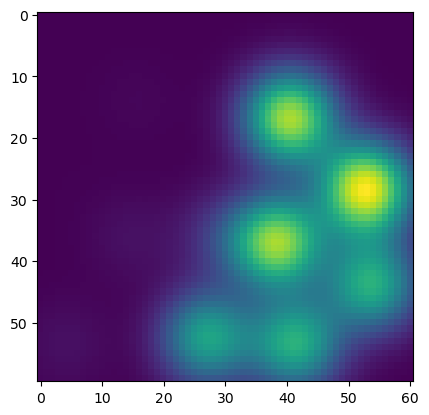

In [7]:
plt.imshow(anchorvox[15,:,:])

## Ligandi

In [8]:
clusters       = 3
embedding_size = clusters * (6 + 3)  # ogni cluster ha : 6 elementi covmat, 3 elementi centro
embedding_size

27

(27,)

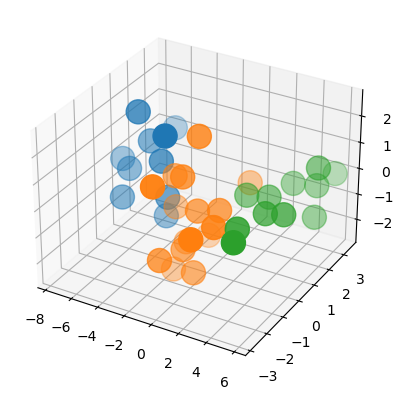

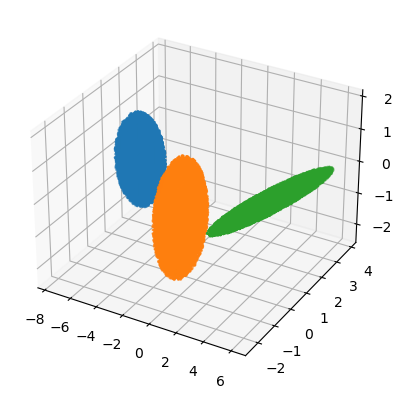

In [9]:
from sklearn.cluster import KMeans

def extract_ligand_information(filename):
    X = list()                            # coordinate atomiche
    A = list()                            # atom list
    
    file1 = open(filename, 'r')           # leggo il file
    Lines = file1.readlines()             # estraggo le linee

    reading_atoms = False
    for line in Lines:
        if line.startswith('@<TRIPOS>ATOM'):
            reading_atoms = True
        else:
            if reading_atoms:
                if line.startswith("@<TRIPOS>BOND"):
                    break
                else:
                    tokenized = line.split()
                    A.append(tokenized[5].split('.')[0])
                    X.append(tokenized[2:5])
    X = np.array(X).astype(float)
    A = np.array(A)
    return X,A

def process_ligand_information(X_,A, visualize = False):
    X = X_ - X_.mean(axis = 0)
    U,s,Vt = np.linalg.svd(X,full_matrices = False)
    X = X @ Vt.T
    
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)
    labels = kmeans.labels_
    
    
    groups = [
            X[labels == l]
        for l in np.unique(labels)
    ]
    
    atoms_in_groups =  [
            A[labels == l]
        for l in np.unique(labels)
    ]
    
    
    def iso(symmat): 
        # isomorfismo matrice simmetrica 3x3 |--> vettore
        return np.array(
            [
                symmat[0,0],
                symmat[0,1],
                symmat[0,2],
                symmat[1,1],
                symmat[1,2],
                symmat[2,2]
            ]
        )
    
    def cov(data):
        data_zc = data - data.mean(axis = 0)
        return  1 / (len(data) - 1) * ( data_zc.T @ data_zc  )
    
    ret = np.array([])
    for g,a in zip(groups,atoms_in_groups):
        #weight = np.sum([ atom_weight[atom] for atom in a])
        #ret = np.r_[ret, weight]                    # peso tot
        ret = np.r_[ret, np.mean(g, axis = 0)]      # centro
        ret = np.r_[ret, iso(cov(g))]
    
    
    if visualize:
        def draw_ellipse(ax,center, cov_mat):
            X = np.random.uniform(size=(30000,3))
            X = (X - X.mean(axis = 0)) * 2.        # sfera di raggio 1
            X = X[np.linalg.norm(X,axis = 1) < 1.]
            X = (cov_mat @ X.T).T + center
            ax.scatter(X[:,0],X[:,1],X[:,2], s = 1.)
        
        ax = plt.figure().add_subplot(projection = '3d')
        for i,g in enumerate(groups):
            ax.scatter(g[:,0],g[:,1],g[:,2],s=300.)
            
        ax = plt.figure().add_subplot(projection = '3d')
        for i,g in enumerate(groups):
            center  = g.mean(axis = 0)
            covar   = cov(g)
            draw_ellipse(ax,center,covar)
    
    return ret
    
test_ligand = "1bnn"
L_X,L_A = extract_ligand_information( data_folder + "%s\\%s_ligand.mol2" % (test_ligand,test_ligand) )
process_ligand_information(L_X,L_A,True).shape

In [10]:
def get_ligand_vectorization(filename):
    L_X,L_A = extract_ligand_information(filename)
    return process_ligand_information(L_X,L_A,False)

# Neural networks micro framework

In [11]:
import jax
import jax.numpy as jnp
from jax import lax
from jax.lax import dynamic_slice

In [12]:
def conv3D(grid,W):
    G = grid.copy()
    def relu(x):
        return jnp.maximum(0,x)
    
    # put zeros "around"
    G = jnp.pad(G,int(W.shape[0]/2))
    
    G = jax.vmap(
            lambda i:
            jax.vmap(
                lambda j:
                jax.vmap(
                    lambda k:
                        ( 
                                (dynamic_slice( G,(i - int(W.shape[0] / 2.) , j - int(W.shape[1] / 2.), k - int(W.shape[2] / 2.)) , 
                                      (W.shape[0],W.shape[1],W.shape[2]) ) * W).sum()
                        )
                )( jnp.arange( int(W.shape[2] / 2.) ,G.shape[2] - int(W.shape[2] / 2.)).astype(int) )
            )( jnp.arange( int(W.shape[1] / 2.), G.shape[1] - int(W.shape[1] / 2.)).astype(int) )
        )( jnp.arange( int(W.shape[0] / 2.), G.shape[0] - int(W.shape[0] / 2.)).astype(int) )
        
    return G
conv3D = jax.jit(conv3D)

In [13]:
def relu(x,w = 1.,b = 0.):
    return jnp.maximum(0,x * w + b)

def sigmoid(x,w = 1.,b = 0.):
    return (jnp.tanh(x * w + b) + 1.)/2.

def tanh(x,w=1.,b=0.):
    return jnp.tanh(x * w + b)

In [14]:
def linear(layer,W,b):
    return W @ layer + b

def add(layer,b):
    return layer + b

# Dataset Loading from Scratch

In [16]:
train_ratio = 0.9

In [17]:
import os

augmentations       = 1

ligand_train        = []
ligand_test         = []
atomcoord_vox_train = []
anchorpts_vox_train = []
atomcoord_vox_test  = []
anchorpts_vox_test  = []

samples = 0
for root, dirnames, filenames in os.walk(data_folder):
        for dirname in dirnames:
            samples +=1
                
count = 0
for root, dirnames, filenames in os.walk(data_folder):
        for dirname in dirnames:
            try:
                pocket_name = dirname + "\\" + dirname+"_pocket.ligen.pdb"
                ligand_name = dirname + "\\" + dirname+"_ligand.mol2"
                
                for j in range(augmentations):
                    whole_ligand_path = "%s\\%s" % (root,ligand_name)
                    L_X,L_A   = extract_ligand_information(whole_ligand_path)
                    
                    if len(L_A) < clusters:
                        raise Exception("Ligand too small!")
                    
                    embedding = process_ligand_information(L_X,L_A)

                    
                    whole_pocket_path = '%s\\%s' % (root,pocket_name)
                    V_X,V_A = extract_voxelization_and_anchor_points_voxelization( whole_pocket_path)
                                        
                    if count <= train_ratio * samples:
                        atomcoord_vox_train.append(V_X)
                        anchorpts_vox_train.append(V_A)
                        ligand_train.append(embedding)
                    else:
                        atomcoord_vox_test.append(V_X)
                        anchorpts_vox_test.append(V_A)    
                        ligand_test.append(embedding)

                count += 1
                if int( count / (samples / 100)) != int( (count + 1)/(samples / 100) ):
                    print("%.2f %% loaded" % (count/samples * 100.) )
            except KeyboardInterrupt:
                break
            except:
                print("Eccezione!")

0.97 % loaded
1.93 % loaded
2.98 % loaded
3.95 % loaded
5.00 % loaded
5.96 % loaded
6.93 % loaded
7.98 % loaded
8.94 % loaded
9.99 % loaded
10.96 % loaded
11.93 % loaded
12.97 % loaded
13.94 % loaded
14.99 % loaded
15.95 % loaded
16.92 % loaded
17.97 % loaded
18.94 % loaded
19.98 % loaded
20.95 % loaded
22.00 % loaded
22.97 % loaded
23.93 % loaded
Eccezione!
24.98 % loaded
25.95 % loaded
Eccezione!
Eccezione!
Eccezione!
Eccezione!
26.99 % loaded
Eccezione!
27.96 % loaded
28.93 % loaded
29.98 % loaded
30.94 % loaded
31.99 % loaded
32.96 % loaded
33.92 % loaded
34.97 % loaded
35.94 % loaded
36.99 % loaded
37.95 % loaded
38.92 % loaded
39.97 % loaded
40.93 % loaded
41.98 % loaded
42.95 % loaded
44.00 % loaded
44.96 % loaded
45.93 % loaded
46.98 % loaded
Eccezione!
47.95 % loaded
Eccezione!
48.99 % loaded
49.96 % loaded
50.93 % loaded
51.97 % loaded
52.94 % loaded
53.99 % loaded
54.96 % loaded
55.92 % loaded
56.97 % loaded
57.94 % loaded
58.98 % loaded
59.95 % loaded
61.00 % loaded
Eccezio

In [19]:
atomcoord_vox_train = [ jnp.array(a) for a in atomcoord_vox_train ]
anchorpts_vox_train = [ jnp.array(a) for a in anchorpts_vox_train ]
atomcoord_vox_test  = [ jnp.array(a) for a in atomcoord_vox_test  ]
anchorpts_vox_test  = [ jnp.array(a) for a in anchorpts_vox_test  ]
ligand_train        = jnp.array([ jnp.array(a) for a in ligand_train        ])
ligand_test         = jnp.array([ jnp.array(a) for a in ligand_test         ])

In [20]:
len(ligand_train), len(ligand_test)

(1117, 107)

In [21]:
shapes = np.array([ np.array(a.shape) for a in atomcoord_vox_train ])
magic_shape = shapes.max(axis = 0)
magic_shape

array([100,  81,  89])

# Saving csvs

In [35]:
for i, atomcoord_vox_train_el, anchorpts_vox_train_el, ligand_train_el             in zip(range(len(ligand_train)),
                                        atomcoord_vox_train,
                                        anchorpts_vox_train,
                                        ligand_train        ):
        
    np.save("csvs_train/atomcoord_vox/atomcoord_vox_train_%d" % i,  np.array(atomcoord_vox_train_el))
    np.save("csvs_train/anchorpts_vox/anchorpts_vox_train_%d" % i,  np.array(anchorpts_vox_train_el))
    np.save("csvs_train/ligand/ligand_train_%d"               % i,  np.array(ligand_train_el))

In [29]:
for i, atomcoord_vox_test_el, anchorpts_vox_test_el, ligand_test_el             in zip(range(len(ligand_test)),
                                        atomcoord_vox_test,
                                        anchorpts_vox_test,
                                        ligand_test        ):
        
    np.save("csvs_test/atomcoord_vox/atomcoord_vox_test_%d" % i,  np.array(atomcoord_vox_test_el))
    np.save("csvs_test/anchorpts_vox/anchorpts_vox_test_%d" % i,  np.array(anchorpts_vox_test_el))
    np.save("csvs_test/ligand/ligand_test_%d"               % i,  np.array(ligand_test_el))

In [34]:
np.linalg.norm(np.load("csvs_test/atomcoord_vox/atomcoord_vox_test_0.npy") - atomcoord_vox_test[0])

0.0

# Loading csvs

In [15]:
import os
N_train = len(next(os.walk("csvs_train/ligand"))[2])
N_test =  len(next(os.walk("csvs_test/ligand"))[2])

# carico il training set
print("Caricamento training set...")
atomcoord_vox_train = []
anchorpts_vox_train = []
ligand_train        = []
for i in range(N_train):
    atomcoord_vox_train_el = jnp.array(np.load("csvs_train/atomcoord_vox/atomcoord_vox_train_%d.npy" % i))
    anchorpts_vox_train_el = jnp.array(np.load("csvs_train/anchorpts_vox/anchorpts_vox_train_%d.npy" % i))
    ligand_train_el        = jnp.array(np.load("csvs_train/ligand/ligand_train_%d.npy" % i))
    
    atomcoord_vox_train.append(atomcoord_vox_train_el)
    anchorpts_vox_train.append(anchorpts_vox_train_el)
    ligand_train.append(ligand_train_el)
    
    if int( i / (N_train / 10)) != int( (i + 1)/ (N_train/10) ):
        print("%d su %d" % (i , N_train))

ligand_train = jnp.array(ligand_train)
    
# carico il test set
print("Caricamento test set...")
atomcoord_vox_test = []
anchorpts_vox_test = []
ligand_test        = []
for i in range(N_test):
    atomcoord_vox_test_el = jnp.array(np.load("csvs_test/atomcoord_vox/atomcoord_vox_test_%d.npy" % i))
    anchorpts_vox_test_el = jnp.array(np.load("csvs_test/anchorpts_vox/anchorpts_vox_test_%d.npy" % i))
    ligand_test_el        = jnp.array(np.load("csvs_test/ligand/ligand_test_%d.npy" % i))
    
    atomcoord_vox_test.append(atomcoord_vox_test_el)
    anchorpts_vox_test.append(anchorpts_vox_test_el)
    ligand_test.append(ligand_test_el)
    
    if int( i / (N_test / 10)) != int( (i + 1)/ (N_test/10) ):
        print("%d su %d" % (i , N_test))
   
ligand_test = jnp.array(ligand_test)

print("check training set ", len(atomcoord_vox_train), len(anchorpts_vox_train), len(ligand_train))
print("check test set ", len(atomcoord_vox_test), len(anchorpts_vox_test), len(ligand_test))

Caricamento training set...
111 su 1117
223 su 1117
335 su 1117
446 su 1117
558 su 1117
670 su 1117
781 su 1117
893 su 1117
1005 su 1117
1116 su 1117
Caricamento test set...
10 su 107
21 su 107
32 su 107
42 su 107
53 su 107
64 su 107
74 su 107
85 su 107
96 su 107
106 su 107
check training set  1117 1117 1117
check test set  107 107 107


In [16]:
shapes = np.array([ np.array(a.shape) for a in atomcoord_vox_train ])
magic_shape = shapes.max(axis = 0)
magic_shape

array([100,  81,  89])

# Padding

In [17]:
def padding(array, requested_shape):
    xx = requested_shape[0]
    yy = requested_shape[1]
    zz = requested_shape[2]
    
    sa = array.shape[0]
    sb = array.shape[1]
    sc = array.shape[2] 
    
    a = (xx - sa) // 2
    aa = xx - a - sa
    b = (yy - sb) // 2
    bb = yy - b - sb
    c = (zz - sc) // 2
    cc = zz - c - sc
    
    return jnp.pad(array, pad_width=((a, aa), (b, bb), (c,cc)), mode='constant')

In [18]:
def extract_batch(magic_shape,source, idx_list):
    return jnp.array([
            padding(source[idx] , magic_shape)
        for idx in idx_list
    ])

# Ligand autoencoder

In [19]:
molecule_embedding_size = 3

In [20]:
def random_autoencoder_params(encoder_topology):
    params_E = []
    params_D = []
    
    
    for cur,nex in zip(encoder_topology[:-1],encoder_topology[1:]):
        params_E.append( 
            jnp.array(
                np.random.randn(nex,cur) * 
                jnp.sqrt(2. / nex) 
            )
        )
        params_E.append(
            jnp.zeros(nex)
        )
        
            
    for cur,nex in zip(encoder_topology[-1::-1][:-1],encoder_topology[-1::-1][1:]):
        params_D.append( 
            jnp.array(
                np.random.randn(nex,cur) * 
                jnp.sqrt(2. / nex) 
            )
        )
        params_D.append(
            jnp.zeros(nex)
        )

        
    return params_E,params_D


def ligand_encoder(params, x):
    W = params[0::2]
    B = params[1::2]
    for w,b in zip(W[:-1],B[:-1]):
        x = linear(x,w,b)
        x = relu(x)
    x = linear(x, W[-1],B[-1])
    return x

def ligand_decoder(params, x):
    W = params[0::2]
    B = params[1::2]
    for w,b in zip(W[:-1],B[:-1]):
        x = linear(x,w,b)
        x = relu(x)
    x = linear(x, W[-1],B[-1])
    return x

np.random.seed(123)


params_E, params_D = random_autoencoder_params([embedding_size,
                                                molecule_embedding_size * 2 , 
                                                molecule_embedding_size])

for e in params_E[0::2]:
    print("dense : INPUT %d\t===>\tOUTPUT %d" % e.shape[-1::-1])
for d in params_D[0::2]:
    print("dense : INPUT %d\t===>\tOUTPUT %d" % d.shape[-1::-1])


lr_E    = [ 0.1 for e in params_E]
lr_D    = [ 0.1 for d in params_D]

def ligand_loss(params_E,params_D,X):
    x = ligand_encoder(params_E,X)
    x = ligand_decoder(params_D,x)
    return jnp.linalg.norm(x - X)


ligand_loss = jax.jit(ligand_loss)
ligand_grad = jax.grad(ligand_loss, argnums = (0,1))
ligand_grad = jax.jit(ligand_grad)


ligand_batched_loss = lambda params_E,params_D,X : jax.vmap(lambda x : ligand_loss(params_E,params_D,x))(X).mean()
ligand_batched_loss = jax.jit(ligand_batched_loss)
ligand_batched_grad = jax.grad(ligand_batched_loss, argnums = (0,1))
ligand_batched_grad = jax.jit(ligand_batched_grad)

jnp_ligand_train = jnp.array(ligand_train)

count = 0


while lr_E[0] > 1e-3:
        batches = np.array_split(
                        np.random.choice(
                            len(ligand_train),
                            len(ligand_train),
                            False
                        ),
                        3
                    )

        
        for b in batches:
            batch = jnp_ligand_train[b]
            g = ligand_batched_grad(params_E,params_D,batch )
            
            new_params_E = [ e - l * gr for e,gr,l in zip(params_E,g[0],lr_E)]
            new_params_D = [ d - l * gr for d,gr,l in zip(params_D,g[1],lr_D)]
            
            if ( ligand_batched_loss(new_params_E,new_params_D,batch).mean() < 
               ligand_batched_loss(params_E,params_D,batch).mean() ):
                lr_E = [ l * 1.1 for l in lr_E]
                lr_D = [ l * 1.1 for l in lr_D]
                params_E = new_params_E
                params_D = new_params_D
            else:
                lr_E = [ l * 0.99 for l in lr_E]
                lr_D = [ l * 0.99 for l in lr_D] 
                    
        if count % 100 == 0:    
            print("TRAIN %.3f\tTEST %.3f,alpha %.3f" % (
                      ligand_batched_loss(params_E,params_D, jnp.array(ligand_train)),
                      ligand_batched_loss(params_E,params_D, jnp.array(ligand_test)),
                      lr_E[0]
                    )
                 )
        count += 1

dense : INPUT 27	===>	OUTPUT 6
dense : INPUT 6	===>	OUTPUT 3
dense : INPUT 3	===>	OUTPUT 6
dense : INPUT 6	===>	OUTPUT 27
TRAIN 9.679	TEST 9.829,alpha 0.133
TRAIN 6.418	TEST 6.312,alpha 0.125
TRAIN 6.100	TEST 5.999,alpha 0.095
TRAIN 5.983	TEST 5.883,alpha 0.089
TRAIN 5.900	TEST 5.796,alpha 0.092
TRAIN 5.612	TEST 5.456,alpha 0.087
TRAIN 5.638	TEST 5.446,alpha 0.073
TRAIN 5.495	TEST 5.279,alpha 0.068
TRAIN 5.445	TEST 5.309,alpha 0.071
TRAIN 5.410	TEST 5.231,alpha 0.067
TRAIN 5.291	TEST 5.077,alpha 0.063
TRAIN 5.419	TEST 5.175,alpha 0.065
TRAIN 5.290	TEST 5.078,alpha 0.068
TRAIN 5.394	TEST 5.160,alpha 0.071
TRAIN 5.208	TEST 5.028,alpha 0.073
TRAIN 4.984	TEST 4.793,alpha 0.077
TRAIN 4.993	TEST 4.826,alpha 0.058
TRAIN 4.926	TEST 4.710,alpha 0.060
TRAIN 4.846	TEST 4.699,alpha 0.057
TRAIN 4.750	TEST 4.550,alpha 0.053
TRAIN 4.802	TEST 4.591,alpha 0.061
TRAIN 4.738	TEST 4.484,alpha 0.052
TRAIN 4.746	TEST 4.570,alpha 0.044
TRAIN 4.736	TEST 4.542,alpha 0.045
TRAIN 4.711	TEST 4.468,alpha 0.053
TRA

TRAIN 4.557	TEST 4.292,alpha 0.054
TRAIN 4.572	TEST 4.302,alpha 0.051
TRAIN 4.533	TEST 4.263,alpha 0.048
TRAIN 4.556	TEST 4.279,alpha 0.055
TRAIN 4.569	TEST 4.292,alpha 0.052
TRAIN 4.551	TEST 4.277,alpha 0.054
TRAIN 4.585	TEST 4.321,alpha 0.050
TRAIN 4.546	TEST 4.264,alpha 0.052
TRAIN 4.567	TEST 4.292,alpha 0.055
TRAIN 4.571	TEST 4.291,alpha 0.051
TRAIN 4.586	TEST 4.329,alpha 0.053
TRAIN 4.582	TEST 4.325,alpha 0.050
TRAIN 4.552	TEST 4.279,alpha 0.052
TRAIN 4.554	TEST 4.292,alpha 0.054
TRAIN 4.569	TEST 4.292,alpha 0.051
TRAIN 4.559	TEST 4.277,alpha 0.059
TRAIN 4.586	TEST 4.324,alpha 0.055
TRAIN 4.562	TEST 4.288,alpha 0.051
TRAIN 4.552	TEST 4.280,alpha 0.060
TRAIN 4.570	TEST 4.300,alpha 0.056
TRAIN 4.577	TEST 4.315,alpha 0.052
TRAIN 4.552	TEST 4.291,alpha 0.049
TRAIN 4.551	TEST 4.277,alpha 0.057
TRAIN 4.545	TEST 4.272,alpha 0.059
TRAIN 4.568	TEST 4.295,alpha 0.055
TRAIN 4.575	TEST 4.306,alpha 0.052
TRAIN 4.567	TEST 4.305,alpha 0.054
TRAIN 4.555	TEST 4.279,alpha 0.056
TRAIN 4.540	TEST 4.2

KeyboardInterrupt: 

In [21]:
ligand_train_zc = ligand_train - np.mean(ligand_train,axis = 0)
U,s,Vt          = np.linalg.svd(ligand_train_zc, full_matrices = False)
m               = molecule_embedding_size
ligand_train_proj = ligand_train_zc   @ Vt.T[:,:m]
ligand_train_rec  = ligand_train_proj @ Vt[:m,:]
np.linalg.norm(ligand_train_rec - ligand_train_zc, axis = 1).mean()

4.5442915

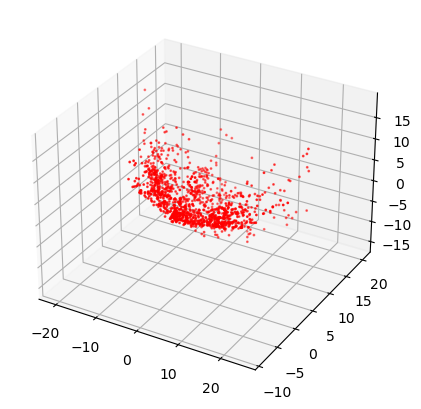

In [22]:
embedding_points = jax.vmap(lambda lt : ligand_encoder(params_E, lt) )(jnp.r_[ligand_train , ligand_test])
ax               = plt.figure(figsize=(5,5)).add_subplot(projection ='3d')
ax.scatter(embedding_points[:,0],
           embedding_points[:,1],
           embedding_points[:,2], s = 1., color = 'red')
plt.show()

# Network

###  Rete

In [67]:
#def chemical_contribution(W,b,W_2,embedding):
#    embedding = ligand_encoder(params_E,embedding)
#    x = linear(embedding,W,b)
#    x = tanh(x)
#    x = linear(x,W_2,0 * W_2[:,0])
#    n = int( (len(W_2) + 1.)**(1./3.) )
#    x = x.reshape(n,n,n)
#    return x


def chemical_contribution(weights_oracle, biases_oracle,embedding):
    x         = ligand_encoder(params_E,embedding)
    for W,b in zip(weights_oracle[:-1], biases_oracle):
        x     = linear(x,W,b)
        x     = relu(x)
        
    W_last    = weights_oracle[-1]
    b_last    = W_last[:,0] * 0            # vettore di zeri
    x         = linear(x, W_last,b_last)
    
    n = int( (len(x) + 1)**(1./3.) )
    x = x.reshape(n,n,n)
    return x

def logistic_model(kernels_tensor_flux, 
                   biases_tensor_flux,
                   weights_oracle,
                   biases_oracle,
                   
                   grid,
                   embedding,
                   alfa):
    
    contribution = chemical_contribution(weights_oracle,biases_oracle, embedding)
    
    x            = conv3D(grid, 
                          kernels_tensor_flux[0] + alfa * contribution)
    x            = relu(x ,
                        b = biases_tensor_flux[0])
    
    for W,b in zip(kernels_tensor_flux[1:][:-1], biases_tensor_flux[1:][:-1]):
        x        = conv3D(x,  W)
        x        = relu(x,b = b)
    
    x            = conv3D(x, kernels_tensor_flux[-1])
    x            =    add(x, biases_tensor_flux[-1] )
    
    return x
    

def generate_params_big_model( flux_topology, oracle_inner_topology, molecule_embedding_size ):
    oracle_topology     = [molecule_embedding_size] + oracle_inner_topology + [flux_topology[0]**3]
    
    kernels_tensor_flux = []
    biases_tensor_flux  = []
    weights_oracle      = []
    biases_oracle       = []
    
    for k in flux_topology:
        kernels_tensor_flux.append( 
            jnp.array(
                np.random.normal(
                    size = (k,k,k)
                ) 
                * 
                np.sqrt(
                    2./ (k * k * k)
                )
            ) 
        )
        biases_tensor_flux.append(0.)
        
    for cur,nex in zip(oracle_topology[:-1], oracle_topology[1:]):
        weights_oracle.append( 
                jnp.array(
                    np.random.randn(nex, cur) 
                    *
                    np.sqrt(1. / nex)
                ) 
        )
        biases_oracle.append(
            jnp.zeros(
                nex
            )
        )
    
    return kernels_tensor_flux, biases_tensor_flux, weights_oracle, biases_oracle
    
ktf, btf, wo, bo = generate_params_big_model( [5,5,5,5], [10] , molecule_embedding_size)
try:
    logistic_model(
        ktf,btf,wo,bo,
        atomcoord_vox_train[0],
        ligand_train[0],
        1.
    )
    print("Parametri inizializzati correttamente")
except:
    print("Parametri inizializzati scorrettamente")

Parametri inizializzati correttamente


### Loss function

In [69]:
def loss(    
                   kernels_tensor_flux, 
                   biases_tensor_flux,
                   weights_oracle,
                   biases_oracle,
         grid,
         embedding,
         alfa,
         A):
    A_hat = logistic_model(
                   kernels_tensor_flux, 
                   biases_tensor_flux,
                   weights_oracle,
                   biases_oracle,
         grid,
         embedding,
         alfa,)
    return ((A - A_hat)**2).mean()
loss = jax.jit(loss)
grad = jax.grad(loss,argnums = (0,1,2,3))
grad = jax.jit(grad)

In [70]:
def batch_loss(    
                   kernels_tensor_flux, 
                   biases_tensor_flux,
                   weights_oracle,
                   biases_oracle,
    
                   grids,
                   embeddings,
                   alfa,
                   As):
    
    
        return jax.vmap(
          lambda 
              grid, embedding, A:
              (
                  (
                    logistic_model(
                           kernels_tensor_flux, 
                           biases_tensor_flux,
                           weights_oracle,
                           biases_oracle,
                        
                           grid,
                           embedding,
                           alfa) 
                      - A)**2 * (A > 0.0)
                   ).mean() / (A > 0.0).mean()
              )(
                  grids,
                  embeddings,
                  As
              ).mean()
    
batch_loss = jax.jit(batch_loss)
batch_grad = jax.grad(batch_loss,argnums = (0,1,2,3))
batch_grad = jax.jit(batch_grad)

# Training

In [1]:
np.random.seed(123)


ktf, btf, wo, bo = generate_params_big_model( [5,5,5,5,5], [10] , molecule_embedding_size)



errors = []
losses = []
alpha  = 1.
for e in range(500):
    print(e)
    batches_n  = 30
    batches    = np.array_split( np.arange(len(anchorpts_vox_train)), batches_n)
    for batch in batches:
        samples = extract_batch(magic_shape,atomcoord_vox_train,batch) #PAD_atomcoord_vox_train[batch]
        ligands = ligand_train[batch]
        labels  = extract_batch(magic_shape,anchorpts_vox_train,batch) #PAD_anchorpts_vox_train[batch]
            
        g      = batch_grad(     ktf, btf, wo, bo,
                                 samples,ligands, alpha, labels)
        lr  = 1e-1
        
        ktf = [ k - lr * gr for k,gr in zip(ktf, g[0])]
        btf = [ b - lr * gr for b,gr in zip(btf, g[1])]
        wo  = [ w - lr * gr for w,gr in zip(wo , g[2])]
        bo  = [ b - lr * gr for b,gr in zip(bo , g[3])]
        
        curr_loss = batch_loss(  ktf, btf, wo, bo,
                                 samples,ligands,alpha,labels)
        
        errors.append(curr_loss)
        losses.append(np.mean(errors[-batches_n:]))
        print("\t%.5f" % curr_loss)
    print(losses[-1])
    
    ##################### check fetta
    
    fetta = 15
    
    axs = plt.figure(figsize=(7,4)).subplots(2,5, sharex = True, sharey = True)
    plt.subplots_adjust(hspace = 0.1, wspace = 0)

    for img in range(5):
        sample = 10 * img
        axs[0,img].imshow( anchorpts_vox_train[sample][fetta,:,:] , cmap = 'coolwarm')
        axs[1,img].imshow( logistic_model(
                                  ktf, btf, wo, bo,
                                  atomcoord_vox_train[sample],
                                  ligand_train[sample], 
                                  1.0)[fetta,:,:] , alpha = 1.0, cmap = 'coolwarm' )
        axs[0,img].set_aspect('equal')
        axs[1,img].set_aspect('equal')


    plt.show()
    
    
plt.figure()
plt.plot(losses)

NameError: name 'np' is not defined

# Test

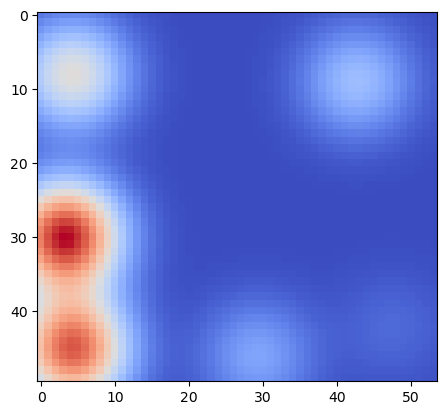

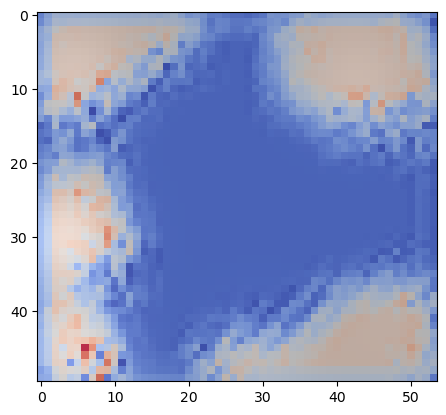

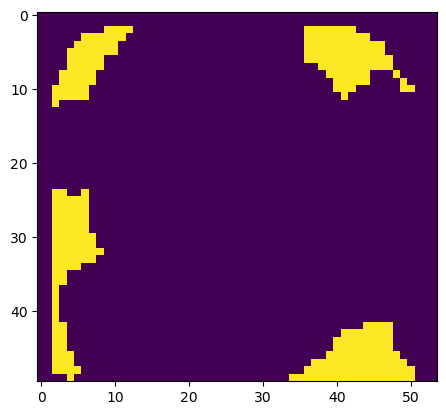

In [44]:
fetta = 50
sample = 1
plt.imshow( anchorpts_vox_train[sample][fetta,:,:] , cmap = 'coolwarm')
plt.figure()
plt.imshow( anchorpts_vox_train[sample][fetta,:,:] , cmap = 'gray')
plt.imshow(logistic_model(W,W_2,W_3,W_4,
                          W_5,b_5,W_6,
                          b_f_1,b_f_2,b_f_3,b_f_4,
                          atomcoord_vox_train[sample],
                          ligand_train[sample], 
                          1.0)[fetta,:,:] , alpha = 0.8, cmap = 'coolwarm' )
plt.figure()
plt.imshow( atomcoord_vox_train[sample][fetta,:,:])
plt.show()

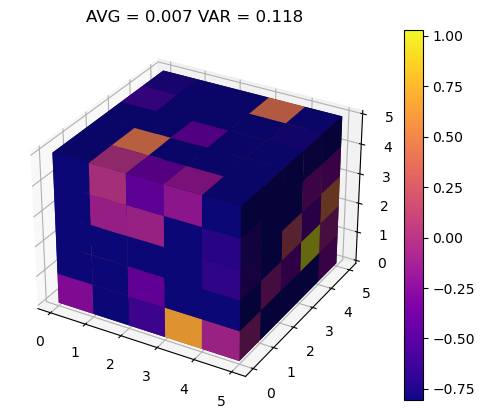

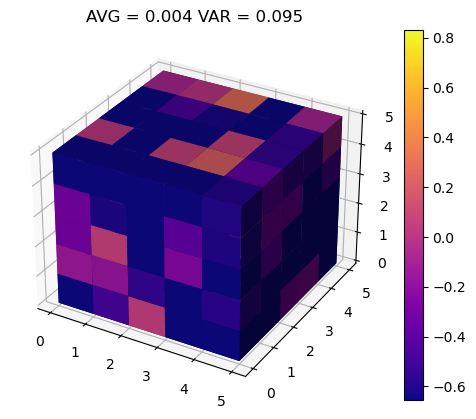

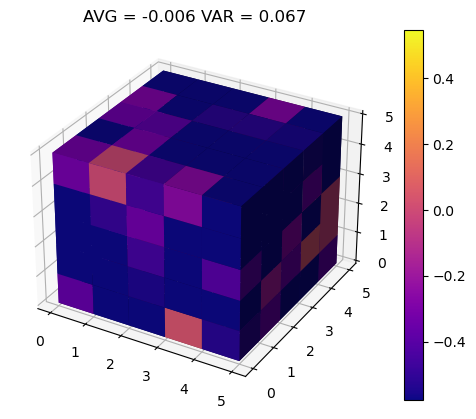

In [34]:
from matplotlib import colors,cm
for s in [10,20,30]:
    fig    = plt.figure()
    ax     = fig.add_subplot(projection = '3d')
    img    = chemical_contribution(W_5,b_5,W_6,ligand_train[s])
    ax.set_title("AVG = %.3f VAR = %.3f" % (img.mean(),img.var()))
    colori = plt.cm.plasma(img)
    v      = ax.voxels( img, facecolors = colori, alpha = 1. )

    norm = colors.Normalize(vmin=img.min(), vmax=img.max())
    m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    m.set_array([])
    plt.colorbar(m)
    plt.show()


In [41]:
sample = 17
V_A_hat = np.array(
logistic_model(W,W_2,W_3,W_4,
                          W_5,b_5,W_6,
                          b_f_1,b_f_2,b_f_3,b_f_4,
                          atomcoord_vox_train[sample],
                          ligand_train[sample], 
                          1.0)
)
V_A     = np.array(anchorpts_vox_test[sample])
V_X     = np.array(atomcoord_vox_test[sample])

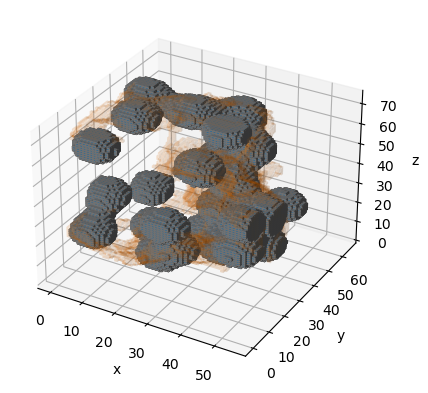

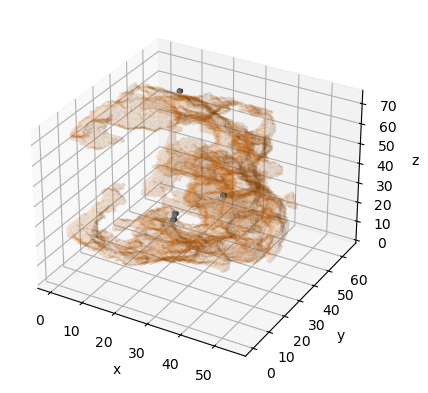

In [42]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

ax = make_ax(True)
ax.voxels(V_A > 0.5, edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

ax = make_ax(True)
ax.voxels(V_A_hat > 0.5, edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

In [40]:
V_A_hat.shape

(53, 71)

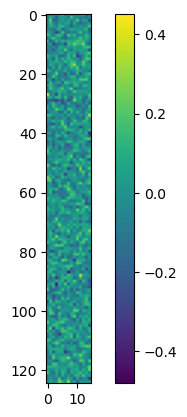

In [64]:
plt.imshow(W_6)
plt.colorbar()

In [127]:
b_f_4

DeviceArray(0.03047841, dtype=float32, weak_type=True)

$f({\bf x} + H_f^{-1} \nabla f({\bf x}) ) \approx f({\bf x}) + \nabla f({\bf x})^T H_f^{-1} \nabla f({\bf x})  + \nabla f({\bf x})^T H_f^{-1}  H_f({\bf x}) H_f^{-1} \nabla f({\bf x}) $

In [57]:
v = np.arange(5)**2
v[[0,2,3]]

array([0, 4, 9])